# A/B Compartment Calling

The data used here is from Su et al, 2020. In the first part of the paper, they adopted a high-resolution whole-chromosome imaging approach to image chromosome 2 and chromosome 21 from IMR90 cell line. Chromosome 2 has more compartment variations and is imaged at a resolution of 250kb for thousands of traces. We chose this as the benchmarking data.

Su, J.-H., Zheng, P., Kinrot, S. S., Bintu, B. & Zhuang, X. Genome-Scale Imaging of the 3D Organization and Transcriptional Activity of Chromatin. Cell 182, 1641-1659.e26 (2020).


In [25]:
import os
import importlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.cluster import KMeans

import dask.array as da
import anndata as ad

from utils import out_dire
from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
su = "../data/su_cell_2020"

## Compartment calling on raw data

In [4]:
loader = sf.pp.FOF_CT_Loader(f"{su}/chromosome2_p-arm_replicate.csv")

In [5]:
p1 = os.path.join(out_dire, "chromosome2_p-arm_replicate.h5ad")
if not os.path.exists(p1):
    adata = loader.create_adata("chr2")
    sf.tl.median_pdist(adata, inplace=True)
    sf.pp.filter_normalize(adata)
    adata.write_h5ad(p1, compression="gzip")
else:
    adata = ad.read_h5ad(p1)
med_dist = adata.varp["med_dist"]

In [6]:
adata

AnnData object with n_obs × n_vars = 4848 × 357
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

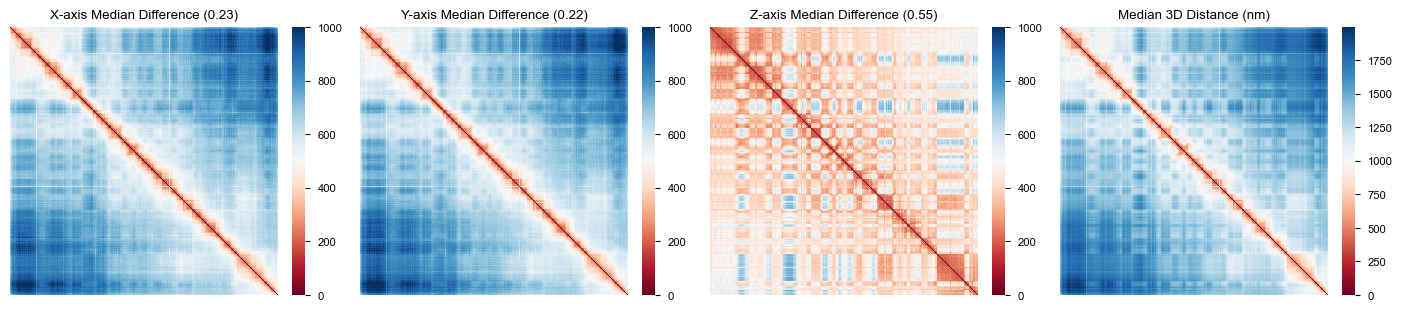

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
wts = sf.pp.axis_weight(adata, inplace=False)
for i, (c, w) in enumerate(zip(["X", "Y", "Z"], wts)):
    mat = adata.varp[f"raw_var_{c}"]**.5
    sf.pl.pairwise_heatmap(mat, ax=axes[i], vmax=1000, rasterized=True)
    axes[i].set_title(f"{c}-axis Median Difference ({w:.2f})")
sf.pl.pairwise_heatmap(med_dist, ax=axes[3], rasterized=True)
axes[3].set_title("Median 3D Distance (nm)")
fig.savefig(os.path.join(out_dire, "su_parm_pdist.pdf"), bbox_inches="tight")

```sh
scp hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/071125/chromosome2_p-arm_replicate.h5ad 123ACElog/072525/.
```

KeyError: 'pdiff_X'

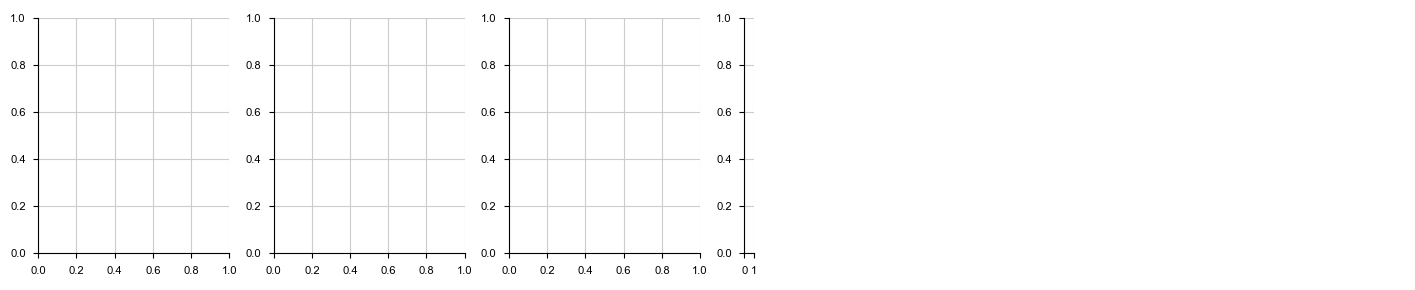

In [8]:
fig = plt.figure(figsize=(14, 2.7))
figs = fig.subfigures(1, 3, width_ratios=[9.05, 3.5, 4])
axes = figs[0].subplots(1, 4, width_ratios=[1, 1, 1, 0.05])
pdiff = np.stack([adata.varp[f"pdiff_{c}"] for c in ["X", "Y", "Z"]])
for i, (c, ax) in enumerate(zip(["X", "Y", "Z"], axes[:3])):
    sf.pl.pairwise_heatmap(pdiff[i], cbar_ax=axes[-1], vmin=0, vmax=1000, rasterized=True, ax=ax)
    ax.set(title=f"{c}-axis Median Pairwise Difference")
ax = figs[1].subplots()
sf.pl.pairwise_heatmap(adata.varp["med_dist"], vmin=0, vmax=2000, rasterized=True,
                       title="Median Pairwise Distance (nm)", ax=ax)

uidx = np.triu_indices_from(pdiff[0], 1)
plt_df = (
    pd.DataFrame(pdiff[:,*uidx], index=["X", "Y", "Z"]).T
    .melt(var_name="axis", value_name="diff")
)
ax = figs[2].subplots()
c1, c2 = plt.colormaps["RdBu"](80), plt.colormaps["RdBu"](200)
sns.violinplot(
    plt_df, x="axis", y="diff", hue="axis", width=0.4, 
    fill=True, alpha=0.5,
    palette={"X": c1, "Y": c1, "Z": c2}, linewidth=1.5, ax=ax,
    inner_kws=dict(box_width=10, whis_width=2, color=sns.color_palette("dark")[0])
)
ax.grid(False)
ax.set(xlabel="", ylabel="Median Pairwise Difference")
fig.savefig(os.path.join(out_dire, "su_parm_pairwise_diff.pdf"), bbox_inches="tight")

In [9]:
caller = sf.tl.ABCaller(0, "hg38", cutoff=500, sigma=1.9, method="pca")
res_sf1 = caller.call_cpmt(adata)
caller = sf.tl.ABCaller(0, "hg38", method="axes")
res_sf2 = caller.call_cpmt(adata)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/tools/cpmt.py:181: UserWarning: Centromere position not found in the chromosome. Calling A/B compartments for the whole chromosome.
  warnings.warn(
/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/tools/cpmt.py:181: UserWarning: Centromere position not found in the chromosome. Calling A/B compartments for the whole chromosome.
  warnings.warn(


In [10]:
import pyBigWig
# Already 250Kb binned, same as su et al
with pyBigWig.open(dtree["rao_cell_2014","imr90","compartments"]) as bw:
    cpmt_vals = []
    for _, row in adata.var.iterrows():
        v = bw.values(adata.uns["Chrom"], row.Chrom_Start, row.Chrom_End)
        v = stats.mode(np.array(v)[~np.isnan(v)])[0]
        cpmt_vals.append([row.Chrom_Start, row.Chrom_End, v])
    cpmt_vals = pd.DataFrame(cpmt_vals, columns=["s1", "e1", "val"])
    cpmt_vals["c1"] = adata.uns["Chrom"]
cpmt_vals = cpmt_vals[["c1", "s1", "e1", "val"]]
cpmt_vals["cpmt"] = (cpmt_vals.val <= 0).astype(int)
len(cpmt_vals)

357

In [11]:
bed_paths = [
    os.path.join(out_dire, "chr2_p-arm_sf1.bed"),
    os.path.join(out_dire, "chr2_p-arm_sf2.bed"),
]
for p, df in zip(bed_paths, [res_sf1, res_sf2]):
    df = df.copy()
    df.iloc[:-1,2] = df["s1"].iloc[1:]
    df[df.cpmt==0].iloc[:,:3].to_csv(
        p, index=False, sep="\t", header=False
    )

In [12]:
adata.var.Chrom_End.max()

94800001

In [13]:
dtree["rao_cell_2014","imr90","compartments"]

'../data/rao_cell_2014/4DNFIHM89EGL.bw'

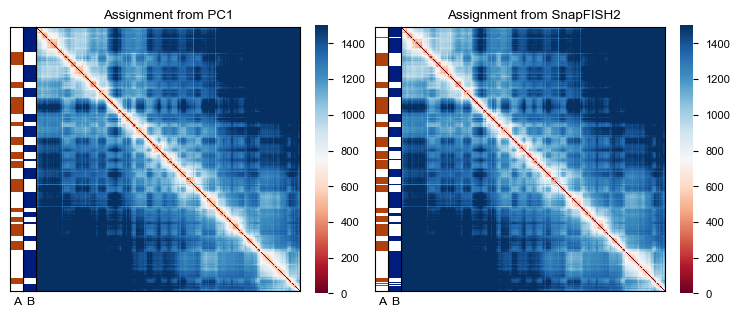

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(7.3, 3))
sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Assignment from PC1")
sf.pl.cpmt_bars(res_sf1.cpmt.values, ax=axes[0])
sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[1])
axes[1].set_title("Assignment from SnapFISH2")
sf.pl.cpmt_bars(res_sf2.cpmt.values, ax=axes[1])
fig.savefig(os.path.join(out_dire, "su_parm_pdist_assign.pdf"), bbox_inches="tight")

In [15]:
cpmt1, cpmt2 = res_sf1.cpmt.values, res_sf2.cpmt.values
np.sum((cpmt1 - cpmt2) != 0), np.sum((cpmt1 - cpmt2) != 0)/len(cpmt1)

(27, 0.07563025210084033)

In [16]:
hic_cpmt = (cpmt_vals.val <= 0).astype(int)
np.sum((cpmt1 - hic_cpmt) != 0), np.sum((hic_cpmt - cpmt2) != 0)

(56, 57)

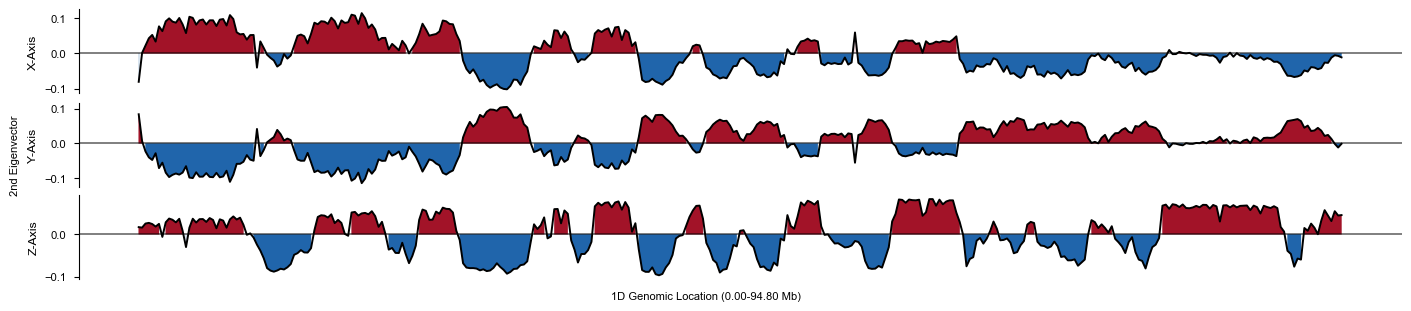

In [17]:
df = res_sf2
fig, axes = plt.subplots(3, 1, figsize=(14, 3), sharex=True)
for i, c in enumerate(["x", "y", "z"]):
    sf.pl.cpmt_vals(df[f"eig_{c}"].values, ax=axes[i])
    axes[i].set_ylabel(f"{c.upper()}-Axis")
dmin, dmax = df["s1"].min()/1e6, df["e1"].max()/1e6
fig.supxlabel(f"1D Genomic Location ({dmin:.2f}-{dmax:.2f} Mb)", fontsize=8)
fig.supylabel("2nd Eigenvector", fontsize=8)
out_name = os.path.join(out_dire, "chr2_parm_eig.pdf")
fig.savefig(out_name, bbox_inches="tight")

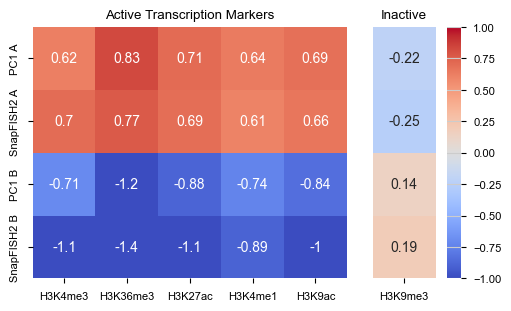

In [18]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata, res_sf1, res_sf2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="SnapFISH2"
)
out_name = os.path.join(out_dire, "chr2_parm_full_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [19]:
for mk in ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac", "H3K9me3"]:
    print(dtree["chipseq_imr90", mk, "bigWig"])

../data/chipseq_imr90/ENCFF518GFI.bigWig
../data/chipseq_imr90/ENCFF314QXF.bigWig
../data/chipseq_imr90/ENCFF222IQN.bigWig
../data/chipseq_imr90/ENCFF148PNW.bigWig
../data/chipseq_imr90/ENCFF682HNO.bigWig
../data/chipseq_imr90/ENCFF733CJA.bigWig


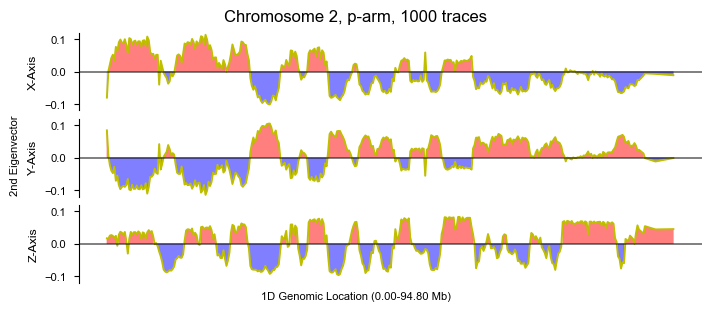

In [20]:
df = res_sf2
fig, axes = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
for i, c in enumerate(["x", "y", "z"]):
    sns.lineplot(df, x="s1", y=f"eig_{c}", color="y", ax=axes[i])
    axes[i].spines['bottom'].set_visible(False)
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines([0], xmin=xmin, xmax=xmax, color="k", alpha=0.5)
    axes[i].set(xlim=(xmin, xmax), ylim=(-0.12, 0.12), xticks=[])
    axes[i].set(ylabel=f"{c}-Axis".title())
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]>=0, 
        alpha=0.5, color="r"
    )
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]<=0, 
        alpha=0.5, color="b"
    )
    axes[i].grid(False)
dmin, dmax = df["s1"].min()/1e6, df["e1"].max()/1e6
fig.supxlabel(f"1D Genomic Location ({dmin:.2f}-{dmax:.2f} Mb)", fontsize=8)
fig.supylabel("2nd Eigenvector", fontsize=8)
fig.suptitle("Chromosome 2, p-arm, 1000 traces")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_eig.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Varying number of traces

```
scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/072525/cpmt_pca_replicate_*" 123ACElog/072525/
scp "hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/072525/cpmt_replicate_*" 123ACElog/072525/
```

In [21]:
pca_df = []
for i in range(10):
    f = os.path.join(out_dire, f"cpmt_pca_replicate_{i}.csv")
    pca_df.append(pd.read_csv(f))
pca_df = pd.concat(pca_df).pivot(
    index="s1", columns=["num_cells", "replicate"], values="cpmt"
)

sf2_df = []
for i in range(10):
    f = os.path.join(out_dire, f"cpmt_replicate_{i}.csv")
    sf2_df.append(pd.read_csv(f))
sf2_df = pd.concat(sf2_df).pivot(
    index="s1", columns=["num_cells", "replicate"], values="cpmt"
)

In [22]:
d1df = adata.var.reset_index(drop=True)
d1df["Chrom"] = adata.uns["Chrom"]
d1df = d1df[["Chrom", "Chrom_Start", "Chrom_End"]]
enrich_df_byn = []
for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker,"peak"], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    
    out_ls = []
    for chr_id in pd.unique(d1df.Chrom):
        sub_df = d1df[d1df["Chrom"]==chr_id].copy()
        ints1 = sub_df.iloc[:,1:].values
        ints2 = chip_df[chip_df["c1"]==chr_id][["s1","e1"]].values
        out_ls.append(sub_df[sf.tl.overlap(ints1, ints2)])
    chipseq_marked = pd.concat(out_ls, ignore_index=True).rename({
        "Chrom":"c1", "Chrom_Start":"s1", "Chrom_End":"e1"
    }, axis=1)["s1"].values
    
    for met, df in zip(["PC1", "SnapFISH2"], [pca_df, sf2_df]):
        marked_count = df.loc[chipseq_marked].sum(axis=0).to_frame("TP_B")
        m, p = len(chipseq_marked), df.shape[0]
        a, b = p - df.sum(axis=0), df.sum(axis=0)
        marked_count["A"] = np.log2(((m - marked_count.TP_B) / a) / (m/p))
        marked_count["B"] = np.log2((marked_count.TP_B / b) / (m/p))
        marked_count = marked_count[["A", "B"]].reset_index().melt(
            id_vars=["num_cells", "replicate"], var_name="cpmt", value_name="fold"
        )
        marked_count["method"] = met
        marked_count["marker"] = marker
        enrich_df_byn.append(marked_count)
enrich_df_byn = pd.concat(enrich_df_byn, ignore_index=True)

In [23]:
hic_df = cpmt_vals.set_index("s1")[["cpmt"]]
hic_enrich = []
for marker in dtree["chipseq_imr90"]:
    chip_df = pd.read_csv(
        dtree["chipseq_imr90",marker,"peak"], sep="\t", 
        header=None, usecols=[0, 1, 2]
    )
    chip_df.columns = ["c1", "s1", "e1"]
    
    out_ls = []
    for chr_id in pd.unique(d1df.Chrom):
        sub_df = d1df[d1df["Chrom"]==chr_id].copy()
        ints1 = sub_df.iloc[:,1:].values
        ints2 = chip_df[chip_df["c1"]==chr_id][["s1","e1"]].values
        out_ls.append(sub_df[sf.tl.overlap(ints1, ints2)])
    chipseq_marked = pd.concat(out_ls, ignore_index=True).rename({
        "Chrom":"c1", "Chrom_Start":"s1", "Chrom_End":"e1"
    }, axis=1)["s1"].values
    
    df = hic_df
    marked_count = df.loc[chipseq_marked].sum(axis=0).to_frame("TP_B")
    m, p = len(chipseq_marked), df.shape[0]
    a, b = p - df.sum(axis=0), df.sum(axis=0)
    marked_count["A"] = np.log2(((m - marked_count.TP_B) / a) / (m/p))
    marked_count["B"] = np.log2((marked_count.TP_B / b) / (m/p))
    marked_count = marked_count[["A", "B"]]
    marked_count["marker"] = marker
    hic_enrich.append(marked_count)
hic_enrich = pd.concat(hic_enrich, ignore_index=True)
hic_enrich.set_index("marker", inplace=True)

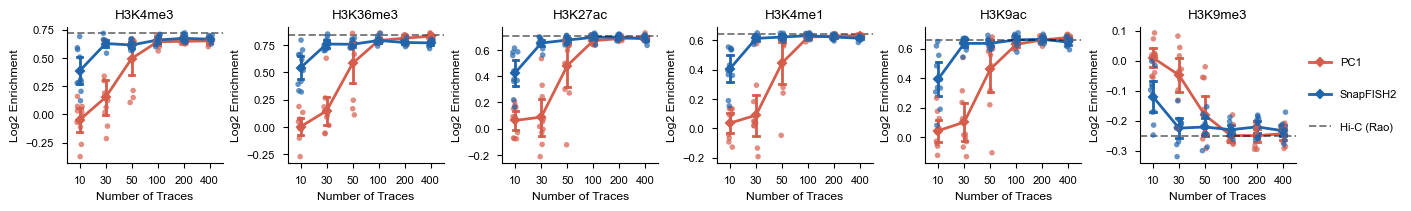

In [24]:
fig, axes = plt.subplots(1, 7, figsize=(14, 2), width_ratios=[1]*6+[0.2])
markers = ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac", "H3K9me3"]
c1, c2 = plt.colormaps.get_cmap("RdBu")(50), plt.colormaps.get_cmap("RdBu")(230)
colors = {"PC1": c1, "SnapFISH2": c2}
for i, marker in enumerate(markers):
    plt_df = enrich_df_byn[enrich_df_byn.marker == marker].copy()
    plt_df["x"] = "abc" + plt_df["num_cells"].astype(str)
    plt_df = plt_df[plt_df.cpmt == "A"]
    sns.pointplot(plt_df, x="x", y="fold", hue="method", errorbar=("se", 2), linewidth=2,
                  capsize=.2, markersize=4, marker="D", palette=colors, ax=axes[i])
    axes[i].axhline(hic_enrich.loc[marker,"A"], color="k", alpha=0.5, linestyle="--", label="Hi-C (Rao)")
    sns.stripplot(plt_df, x="x", y="fold", hue="method", 
                  palette=colors, alpha=.7, s=4, ax=axes[i])
    axes[i].set(title=marker, xlabel="Number of Traces", ylabel="Log2 Enrichment")
    xticklabels = [t.get_text()[3:] for t in axes[i].get_xticklabels()]
    axes[i].set(xticks=axes[i].get_xticks(), xticklabels=xticklabels)
    axes[i].grid(False)
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
axes[6].legend(handles[:3], labels[:3], loc="center", labelspacing=2, bbox_to_anchor=(0.5, 0.5))
axes[6].axis("off")
fig.savefig(os.path.join(out_dire, "chr2_parm_enrich_point.pdf"), bbox_inches="tight")

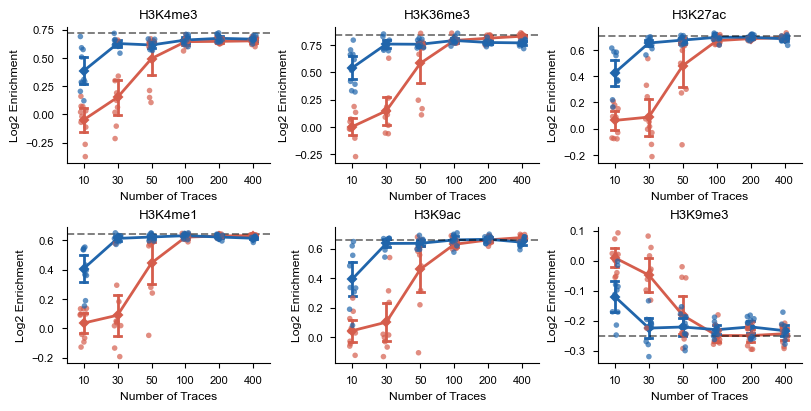

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))
axes = axes.flatten()
markers = ["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac", "H3K9me3"]
c1, c2 = plt.colormaps.get_cmap("RdBu")(50), plt.colormaps.get_cmap("RdBu")(230)
colors = {"PC1": c1, "SnapFISH2": c2}
for i, marker in enumerate(markers):
    plt_df = enrich_df_byn[enrich_df_byn.marker == marker].copy()
    plt_df["x"] = "abc" + plt_df["num_cells"].astype(str)
    plt_df = plt_df[plt_df.cpmt == "A"]
    sns.pointplot(plt_df, x="x", y="fold", hue="method", errorbar=("se", 2), linewidth=2,
                  capsize=.2, markersize=4, marker="D", palette=colors, ax=axes[i])
    axes[i].axhline(hic_enrich.loc[marker,"A"], color="k", alpha=0.5, linestyle="--", label="Hi-C (Rao)")
    sns.stripplot(plt_df, x="x", y="fold", hue="method", 
                  palette=colors, alpha=.7, s=4, ax=axes[i])
    axes[i].set(title=marker, xlabel="Number of Traces", ylabel="Log2 Enrichment")
    xticklabels = [t.get_text()[3:] for t in axes[i].get_xticklabels()]
    axes[i].set(xticks=axes[i].get_xticks(), xticklabels=xticklabels)
    axes[i].grid(False)
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
fig.savefig(os.path.join(out_dire, "chr2_parm_enrich_point.png"), dpi=800, bbox_inches="tight")

In [26]:
for marker in markers:
    plt_df = enrich_df_byn[enrich_df_byn.marker == marker].copy()
    sub_df = plt_df[(plt_df["num_cells"]==30)&(plt_df.cpmt == "A")]
    x = sub_df[sub_df["method"]=="PC1"].fold.values
    y = sub_df[sub_df["method"]=="SnapFISH2"].fold.values
    print(f"mean1: {x.mean():.4f}, mean2: {y.mean():.4f}", end=", ")
    print(f"P-value={stats.mannwhitneyu(x, y)[1]:.4f}")

mean1: 0.1517, mean2: 0.6285, P-value=0.0017
mean1: 0.1470, mean2: 0.7571, P-value=0.0002
mean1: 0.0880, mean2: 0.6527, P-value=0.0002
mean1: 0.0889, mean2: 0.6127, P-value=0.0002
mean1: 0.1026, mean2: 0.6350, P-value=0.0002
mean1: -0.0476, mean2: -0.2248, P-value=0.0013


In [27]:
hic_enrich

A         B
marker                      
CTCF      0.524054 -0.825065
POLR2A    0.749474 -1.632067
SMC3      0.623225 -1.111839
H3K4me3   0.722634 -1.500461
H3K27ac   0.707329 -1.431457
H3K27me3  0.318155 -0.406134
H3K4me1   0.643547 -1.181229
H3K36me3  0.841108 -2.231104
H3K9me3  -0.251454  0.212952
H3K9ac    0.658550 -1.235361
H3K4me2   0.544615 -0.878505
H3K79me2  0.875723 -2.558624
H4K20me1  0.831866 -2.156039

## Fewer traces and whole chromosome

In [28]:
adata3 = loader.create_adata("chr2")[:30]
med_dist3 = sf.tl.median_pdist(adata3, inplace=False)
sf.pp.filter_normalize(adata3)

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/eval.py:34: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = raw_var[i]


In [ ]:
caller = sf.tl.ABCaller(0, "hg38", False, cutoff=500, sigma=1.9, method="pca")
res_sf1_sub = caller.call_cpmt(adata3)
caller = sf.tl.ABCaller(0, "hg38", False, method="axes")
res_sf2_sub = caller.call_cpmt(adata3)

In [30]:
bed_paths = [
    os.path.join(out_dire, "chr2_p-arm_replicate_hic.bed"),
    os.path.join(out_dire, "chr2_p-arm_replicate_sf1.bed"),
    os.path.join(out_dire, "chr2_p-arm_replicate_sf2.bed"),
]
for p, df in zip(bed_paths, [cpmt_vals, res_sf1_sub, res_sf2_sub]):
    df = df.copy()
    df.iloc[:-1,2] = df["s1"].iloc[1:]
    df[df.cpmt==0].iloc[:,:3].to_csv(
        p, index=False, sep="\t", header=False
    )

In [31]:
df.iloc[2,:-1]

c1             chr2
s1           500001
e1           750001
cpmt              1
eig_x     -0.015923
eig_y      0.050573
eig_z     -0.018013
wteig_x   -0.003946
wteig_y    0.015805
Name: 2, dtype: object

In [32]:
adata3.var["Chrom_End"].max()

94800001

In [33]:
dtree["chipseq_imr90", "H3K27ac", "bigWig"]

'../data/chipseq_imr90/ENCFF222IQN.bigWig'

In [34]:
dtree["chipseq_imr90", "H3K4me1", "bigWig"]

'../data/chipseq_imr90/ENCFF148PNW.bigWig'

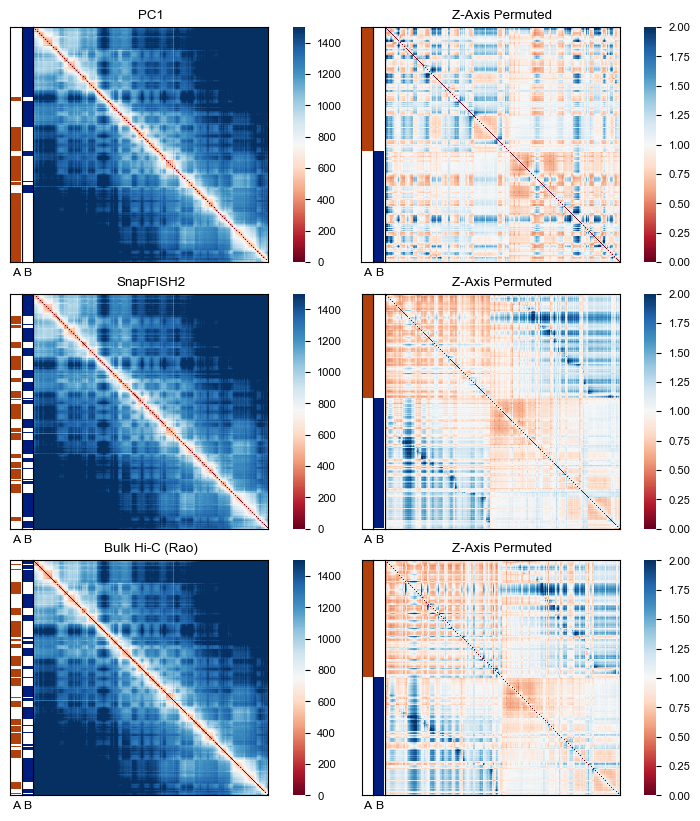

In [35]:
from utils.maps import permute_cpmt_heatmap
fig, axes = plt.subplots(3, 2, figsize=(7, 8))
axes = axes.flatten()

sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("PC1")
sf.pl.cpmt_bars(res_sf1_sub.cpmt.values, ax=axes[0])
permute_cpmt_heatmap(res_sf1_sub.cpmt.values, adata, axes[1])

sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("SnapFISH2")
sf.pl.cpmt_bars(res_sf2_sub.cpmt.values, ax=axes[2])
permute_cpmt_heatmap(res_sf2_sub.cpmt.values, adata, axes[3])

sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[4])
axes[4].set_title("Bulk Hi-C (Rao)")
sf.pl.cpmt_bars(cpmt_vals.cpmt.values, ax=axes[4])
permute_cpmt_heatmap(cpmt_vals.cpmt.values, adata, axes[5])

fig.savefig(os.path.join(out_dire, "su_parm_sub_assign.pdf"), bbox_inches="tight")

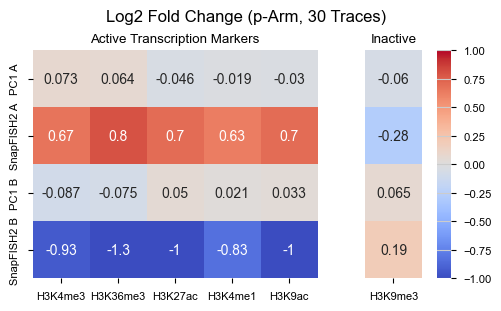

In [36]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata, res_sf1_sub, res_sf2_sub, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="SnapFISH2"
)
fig.suptitle("Log2 Fold Change (p-Arm, 30 Traces)")
out_name = os.path.join(out_dire, "chr2_parm_30tr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

```sh
scp 123ACElog/051625/chromosome2.h5ad hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/051625/chromosome2.h5ad
scp hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/051625/chromosome2.h5ad 123ACElog/051625/chromosome2.h5ad

scp hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/071125/chromosome2.h5ad 123ACElog/071125/.
```

In [15]:
loader2 = sf.pp.FOF_CT_Loader(f"{su}/chromosome2.csv")
p2 = os.path.join(out_dire, "chromosome2.h5ad")
if not os.path.exists(p2):
    adata2 = loader2.create_adata("chr2")
    sf.tl.median_pdist(adata2, inplace=True)
    sf.pp.filter_normalize(adata2)
    adata2.write_h5ad(p2, compression="gzip")
else:
    adata2 = ad.read_h5ad(p2)
med_dist2 = adata2.varp["med_dist"]

In [16]:
adata2

AnnData object with n_obs × n_vars = 3029 × 935
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

In [17]:
import pyBigWig
# Already 250Kb binned, same as su et al
with pyBigWig.open(dtree["rao_cell_2014","imr90","compartments"]) as bw:
    cpmt_vals_2 = []
    for _, row in adata2.var.iterrows():
        v = bw.values(adata2.uns["Chrom"], row.Chrom_Start, row.Chrom_End)
        v = stats.mode(np.array(v)[~np.isnan(v)])[0]
        cpmt_vals_2.append([row.Chrom_Start, row.Chrom_End, v])
    cpmt_vals_2 = pd.DataFrame(cpmt_vals_2, columns=["s1", "e1", "val"])
cpmt_vals_2["cpmt"] = (cpmt_vals_2.val <= 0).astype(int)
len(cpmt_vals_2)

935

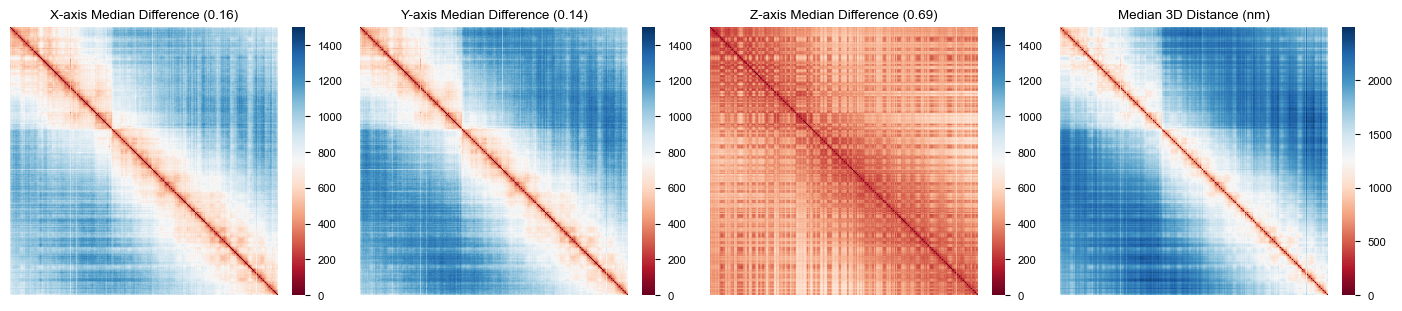

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
wts = sf.pp.axis_weight(adata2, inplace=False)
for i, (c, w) in enumerate(zip(["X", "Y", "Z"], wts)):
    mat = adata2.varp[f"raw_var_{c}"]**.5
    sf.pl.pairwise_heatmap(mat, ax=axes[i], vmax=1500, rasterized=True)
    axes[i].set_title(f"{c}-axis Median Difference ({w:.2f})")
sf.pl.pairwise_heatmap(med_dist2, ax=axes[3], rasterized=True)
axes[3].set_title("Median 3D Distance (nm)")
fig.savefig(os.path.join(out_dire, "su_chr2_pdist.pdf"), bbox_inches="tight")

KeyError: 'pdiff_X'

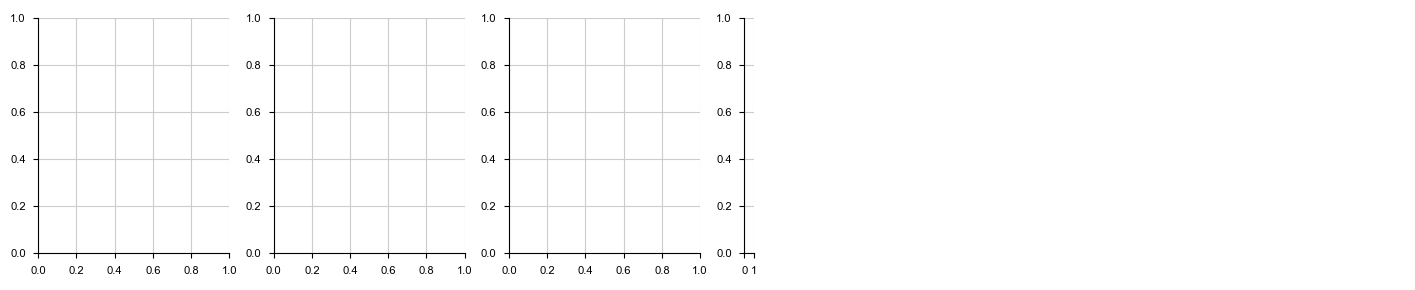

In [41]:
fig = plt.figure(figsize=(14, 2.7))
figs = fig.subfigures(1, 3, width_ratios=[9.05, 3.5, 4])
axes = figs[0].subplots(1, 4, width_ratios=[1, 1, 1, 0.05])
pdiff = np.stack([adata2.varp[f"pdiff_{c}"] for c in ["X", "Y", "Z"]])
for i, (c, ax) in enumerate(zip(["X", "Y", "Z"], axes[:3])):
    sf.pl.pairwise_heatmap(pdiff[i], cbar_ax=axes[-1], vmin=0, vmax=1000, rasterized=True, ax=ax)
    ax.set(title=f"{c}-axis Median Pairwise Difference")
ax = figs[1].subplots()
sf.pl.pairwise_heatmap(adata2.varp["med_dist"], vmin=0, vmax=2000, rasterized=True,
                       title="Median Pairwise Distance (nm)", ax=ax)

uidx = np.triu_indices_from(pdiff[0], 1)
plt_df = (
    pd.DataFrame(pdiff[:,*uidx], index=["X", "Y", "Z"]).T
    .melt(var_name="axis", value_name="diff")
)
ax = figs[2].subplots()
c1, c2 = plt.colormaps["RdBu"](80), plt.colormaps["RdBu"](200)
sns.violinplot(
    plt_df, x="axis", y="diff", hue="axis", width=0.4, 
    fill=True, alpha=0.5,
    palette={"X": c1, "Y": c1, "Z": c2}, linewidth=1.5, ax=ax,
    inner_kws=dict(box_width=10, whis_width=2, color=sns.color_palette("dark")[0])
)
ax.grid(False)
ax.set(xlabel="", ylabel="Median Pairwise Difference")
fig.savefig(os.path.join(out_dire, "su_chr2_pairwise_diff.pdf"), bbox_inches="tight")

In [22]:
caller = sf.tl.ABCaller(0, "hg38", False, cutoff=500, sigma=1.9, method="pca")
res_sf1_chr2 = caller.call_cpmt(adata2)
caller = sf.tl.ABCaller(0, "hg38", False, method="axes")
res_sf2_chr2 = caller.call_cpmt(adata2)

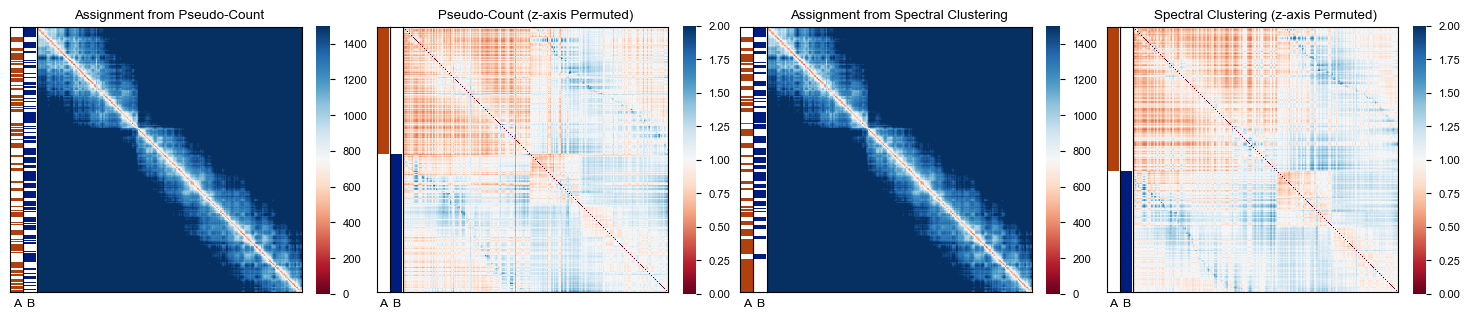

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(14.6, 3))
sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Assignment from Pseudo-Count")
sf.pl.cpmt_bars(cpmt_vals_2.cpmt.values, ax=axes[0])

cpmt_arr = cpmt_vals_2.cpmt.values
idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(adata2.varp["var_Z"][idx][:,idx], ax=axes[1], 
                       vmax=2, rasterized=True)
sf.pl.cpmt_bars(perm_cpmt, ax=axes[1])
axes[1].set_title("Pseudo-Count (z-axis Permuted)")

sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("Assignment from Spectral Clustering")
sf.pl.cpmt_bars(res_sf2_chr2.cpmt.values, ax=axes[2])

cpmt_arr = res_sf2_chr2.cpmt.values
idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(adata2.varp["var_Z"][idx][:,idx], ax=axes[3], 
                       vmax=2, rasterized=True)
sf.pl.cpmt_bars(perm_cpmt, ax=axes[3])
axes[3].set_title("Spectral Clustering (z-axis Permuted)")

fig.savefig(os.path.join(out_dire, "su_chr2_sub_assign.pdf"), bbox_inches="tight")

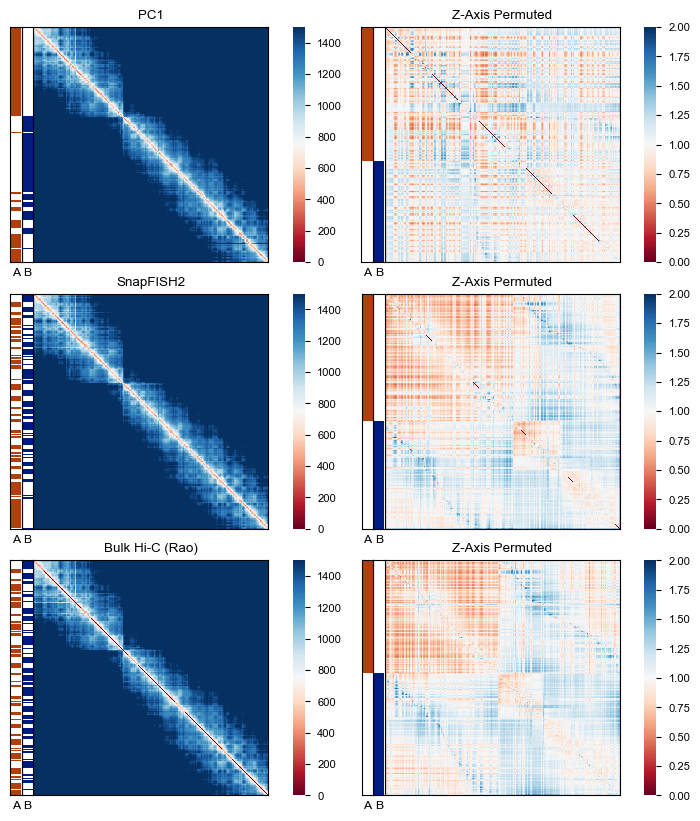

In [44]:
from utils.maps import permute_cpmt_heatmap
fig, axes = plt.subplots(3, 2, figsize=(7, 8))
axes = axes.flatten()

sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("PC1")
sf.pl.cpmt_bars(res_sf1_chr2.cpmt.values, ax=axes[0])
permute_cpmt_heatmap(res_sf1_chr2.cpmt.values, adata2, axes[1])

sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("SnapFISH2")
sf.pl.cpmt_bars(res_sf2_chr2.cpmt.values, ax=axes[2])
permute_cpmt_heatmap(res_sf2_chr2.cpmt.values, adata2, axes[3])

sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[4])
axes[4].set_title("Bulk Hi-C (Rao)")
sf.pl.cpmt_bars(cpmt_vals_2.cpmt.values, ax=axes[4])
permute_cpmt_heatmap(cpmt_vals_2.cpmt.values, adata2, axes[5])

fig.savefig(os.path.join(out_dire, "su_chr2_assign.pdf"), bbox_inches="tight")

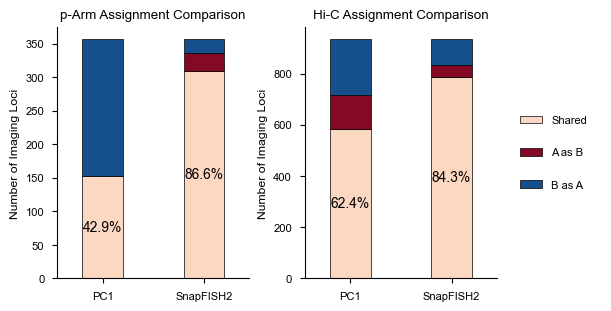

In [45]:
shared_color = plt.colormaps["RdBu"](100)
raw_spe_color = plt.colormaps["RdBu"](10)
noi_spe_color = plt.colormaps["RdBu"](240)
color=[shared_color, raw_spe_color, noi_spe_color]

fig, axes = plt.subplots(1, 3, figsize=(6, 3), width_ratios=[1, 1, .5])
diff = res_sf1.cpmt.values - res_sf1_chr2.cpmt.values[:len(res_sf1)]
plt_df1 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("PC1")
diff = res_sf2.cpmt.values - res_sf2_chr2.cpmt.values[:len(res_sf2)]
plt_df2 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("SnapFISH2")
plt_df = pd.concat([plt_df1, plt_df2], axis=1)
plt_df.T.plot(kind="bar", stacked=True, linewidth=.5, edgecolor="k",
            color=color, width=0.4, ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].set(title="p-Arm Assignment Comparison")

diff = cpmt_vals_2.cpmt.values - res_sf1_chr2.cpmt.values[:len(cpmt_vals_2)]
plt_df1 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("PC1")
diff = cpmt_vals_2.cpmt.values - res_sf2_chr2.cpmt.values[:len(cpmt_vals_2)]
plt_df2 = pd.Series({"Shared": np.nansum(diff==0), "A as B": np.nansum(diff==-1), 
                     "B as A": np.nansum(diff==1)}).to_frame("SnapFISH2")
plt_df = pd.concat([plt_df1, plt_df2], axis=1)
plt_df.T.plot(kind="bar", stacked=True, linewidth=.5, edgecolor="k",
            color=color, width=0.4, ax=axes[1])
handles, labels = axes[0].get_legend_handles_labels()
axes[1].set(title="Hi-C Assignment Comparison")

for i in range(2):
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    axes[i].set(ylabel="Number of Imaging Loci")
    axes[i].get_legend().remove()
    axes[i].grid(False)
    
    bar = axes[1].patches[i]
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                f"{bar.get_height()/len(cpmt_vals_2)*100:.1f}%", ha="center", verticalalignment="center")
    bar = axes[0].patches[i]
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                f"{bar.get_height()/len(res_sf1)*100:.1f}%", ha="center", verticalalignment="center")


axes[2].legend(handles[:3], labels[:3], loc="center", labelspacing=2, bbox_to_anchor=(0.5, 0.5))
axes[2].axis("off")
fig.savefig(os.path.join(out_dire, "su_chr2_assign_comp.pdf"), bbox_inches="tight")

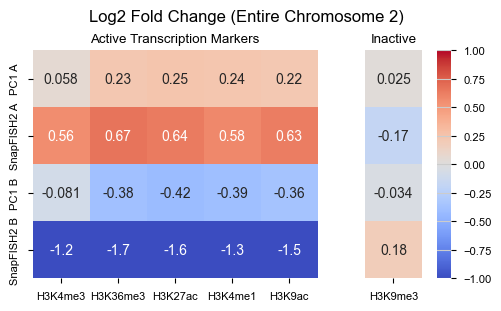

In [24]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata2, res_sf1_chr2, res_sf2_chr2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="SnapFISH2"
)
fig.suptitle("Log2 Fold Change (Entire Chromosome 2)")
out_name = os.path.join(out_dire, "chr2_3ktr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Weighted versus unweighted eigenvectors

In [47]:
df1 = res_sf2_chr2.copy()
df1["cpmt"] = KMeans(2, random_state=0).fit_predict(df1[["eig_x", "eig_y", "eig_z"]])
df2 = res_sf2_chr2.copy()
df2["cpmt"] = 1 - KMeans(2, random_state=0).fit_predict(df2[["wteig_x", "wteig_y", "wteig_z"]])

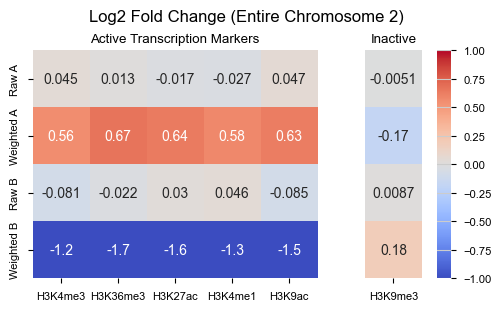

In [48]:
fig = cpmt_enrichment(
    adata2, df1, df2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="Raw", name2="Weighted"
)
fig.suptitle("Log2 Fold Change (Entire Chromosome 2)")
out_name = os.path.join(out_dire, "chr2_wteig_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

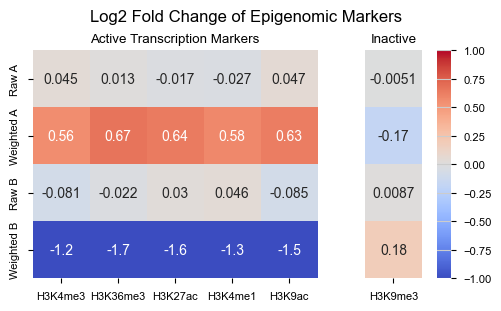

In [49]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata2, df1, df2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="Raw", name2="Weighted"
)
fig.suptitle("Log2 Fold Change of Epigenomic Markers")
out_name = os.path.join(out_dire, "chr2_wteig_log2.png")
fig.savefig(out_name, bbox_inches="tight", dpi=800)

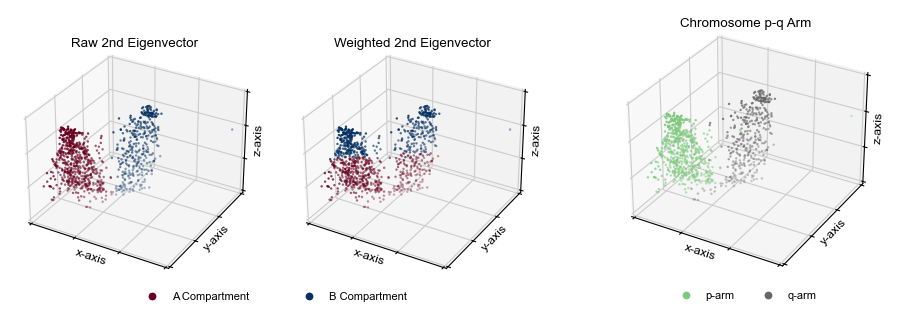

In [50]:
fig = plt.figure(figsize=(9, 3))
figs = fig.subfigures(1, 3, width_ratios=[2, 0.1, 1.1])
ax = figs[0].add_subplot(121, projection="3d")
s1 = ax.scatter(*df1.iloc[:,4:7].values.T, c=df1["cpmt"], s=3, linewidths=0, cmap="RdBu")
ax.set_title("Raw 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s1.legend_elements()[0][:1], ["A Compartment"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center right"
)

ax = figs[0].add_subplot(122, projection="3d")
ax.scatter(*df2.iloc[:,7:10].values.T, c=df2["cpmt"], s=3, linewidths=0, cmap="RdBu")
ax.set_title("Weighted 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s1.legend_elements()[0][1:], ["B Compartment"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center left"
)

ax = figs[2].add_subplot(projection="3d")
c = df1["e1"] < 91855520  # centromere position
s2 = ax.scatter(*df1.iloc[:,4:7].values.T, c=c, s=3, linewidths=0, cmap="Accent")
ax.set_title("Chromosome p-q Arm", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s2.legend_elements()[0], ["p-arm", "q-arm"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center"
)

fig.savefig(os.path.join(out_dire, "chr2_kmeans.pdf"), bbox_inches="tight")

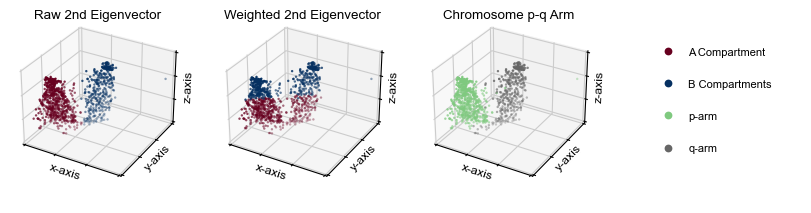

In [51]:
fig2 = plt.figure(figsize=(8, 2))
ax = fig2.add_subplot(141, projection="3d")
s1 = ax.scatter(*df1.iloc[:,4:7].values.T, c=df1["cpmt"], s=3, linewidths=0, cmap="RdBu")
ax.set_title("Raw 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(s1.legend_elements()[0], ["A Compartment", "B Compartments"])
handles1, labels1 = ax.get_legend_handles_labels()
ax.get_legend().set_visible(False)

ax = fig2.add_subplot(142, projection="3d")
ax.scatter(*df2.iloc[:,7:10].values.T, c=df2["cpmt"], s=3, linewidths=0, cmap="RdBu")
ax.set_title("Weighted 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})

ax = fig2.add_subplot(143, projection="3d")
c = df1["e1"] < 91855520  # centromere position
s2 = ax.scatter(*df1.iloc[:,4:7].values.T, c=c, s=3, linewidths=0, cmap="Accent")
ax.set_title("Chromosome p-q Arm", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
handles2, labels2 = ax.get_legend_handles_labels()
    
ax = fig2.add_subplot(144)
ax.legend(
    s1.legend_elements()[0] + s2.legend_elements()[0], 
    ["A Compartment", "B Compartments", "p-arm", "q-arm"], loc="center", labelspacing=2, 
    bbox_to_anchor=(0.5, 0.5), ncol=1
)
ax.axis("off")

fig2.savefig(os.path.join(out_dire, "chr2_kmeans.png"), dpi=800, bbox_inches="tight")

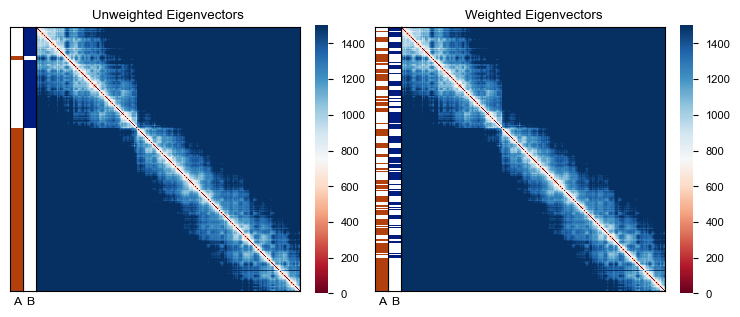

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(7.3, 3))
sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Unweighted Eigenvectors")
sf.pl.cpmt_bars(df1.cpmt.values, ax=axes[0])
sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[1])
axes[1].set_title("Weighted Eigenvectors")
sf.pl.cpmt_bars(df2.cpmt.values, ax=axes[1])
fig.savefig(os.path.join(out_dire, "chr2_wtunwt_assign.pdf"), bbox_inches="tight")

In [ ]:
https://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/gap.txt.gz

In [ ]:
https://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/cytoBandIdeo.txt.gz

In [5]:
url

'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/hg38/database/gap.txt.gz'

In [35]:
import requests
from io import BytesIO, TextIOWrapper
import gzip
ref_genome = "mm10"
pre = "https://hgdownload.soe.ucsc.edu/goldenPath"
url2 = f"{pre}/{ref_genome}/database/gap.txt.gz"
response2 = requests.get(url2)

with gzip.GzipFile(fileobj=BytesIO(response2.content)) as gz:
    gap_table = pd.read_csv(
        TextIOWrapper(gz), sep="\t", 
        header=None
    )

gap_table.columns = ["bin", "Chrom", "Chrom_Start", "Chrom_End",
                     "ix", "n", "size", "type", "bridge"]

# gap_table[gap_table["type"]=="centromere"]
sub_table = gap_table[gap_table["type"]=="centromere"]

In [36]:
(
            sub_table
            .sort_values("Chrom_End")
            .groupby("Chrom", sort=False).head(1)
            .set_index("Chrom")["Chrom_End"].to_dict()
        )

{'chr1': 3000000,
 'chr8': 3000000,
 'chr7': 3000000,
 'chr6': 3000000,
 'chr5': 3000000,
 'chr4': 3000000,
 'chr3': 3000000,
 'chr2': 3000000,
 'chr19': 3000000,
 'chr18': 3000000,
 'chr17': 3000000,
 'chr16': 3000000,
 'chr15': 3000000,
 'chr14': 3000000,
 'chr13': 3000000,
 'chr12': 3000000,
 'chr11': 3000000,
 'chr10': 3000000,
 'chr9': 3000000,
 'chrX': 3000000}

In [23]:
import requests, warnings, gzip
from io import BytesIO, TextIOWrapper

# ref_genome = ref_genome.lower()
ref_genome = "hg38"
pre = "https://hgdownload.soe.ucsc.edu/goldenPath"
url = f"{pre}/{ref_genome}/database/cytoBandIdeo.txt.gz"
try:
    response = requests.get(url)
    response.raise_for_status()
except requests.exceptions.HTTPError:
    warnings.warn(
        f"{ref_genome} not found in UCSC. \n" + 
        "See available assembly IDs at: " +
        "https://genome.ucsc.edu/cgi-bin/hgGateway"
    )

with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
    band_table = pd.read_csv(
        TextIOWrapper(gz), sep="\t", 
        header=None
    )

band_table.columns = ["Chrom", "Chrom_Start", "Chrom_End", "name", "gieStain"]

centromeres = (
    band_table[band_table["gieStain"]=="acen"]
    .sort_values("Chrom_End")
    .groupby("Chrom", sort=False).head(1)
    .set_index("Chrom")["Chrom_End"].to_dict()
)

In [12]:
adata[:,adata.var["Chrom_End"] < 1e7]

View of AnnData object with n_obs × n_vars = 4848 × 40
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

In [7]:
adata.var["Chrom_End"]

locus
loc0         50001
loc1        300001
loc2        550001
loc3        800001
loc4       1050001
            ...   
loc352    89050001
loc353    89800001
loc354    90050001
loc355    91800001
loc356    94800001
Name: Chrom_End, Length: 357, dtype: int64

In [24]:
centromeres

{'chrY': 10400000,
 'chr21': 12000000,
 'chr22': 15000000,
 'chr14': 17200000,
 'chr13': 17700000,
 'chr18': 18500000,
 'chr15': 19000000,
 'chr17': 25100000,
 'chr19': 26200000,
 'chr20': 28100000,
 'chr12': 35500000,
 'chr16': 36800000,
 'chr10': 39800000,
 'chr9': 43000000,
 'chr8': 45200000,
 'chr5': 48800000,
 'chr4': 50000000,
 'chr11': 53400000,
 'chr6': 59800000,
 'chr7': 60100000,
 'chrX': 61000000,
 'chr3': 90900000,
 'chr2': 93900000,
 'chr1': 123400000}